# Uniview module for [M82](https://en.wikipedia.org/wiki/Messier_82) 

I will use the  [FIRE](https://galaxies.northwestern.edu/fire-simulations/) isolated galaxy model that we've used for testing [Firefly](https://github.com/ageller/Firefly) here.  That simulation’s “proper name” is control_G4_020 and was run by Paul Torrey as part of his nuclear star formation paper.  Note, the bi-conical outflow in the simulation  is due to AGN feedback, so scientifically this isn’t accurate.  But the look should be fine for our purposes. 

*Aaron Geller, 2019*

### Imports and function definitions

In [5]:
#This directory contains all the data needed for the module. It should be in the same directory as the notebook
dataFolder = "data"

import sys, os, shutil, errno, string, urllib

sys.path.append(( os.path.abspath( os.path.join(os.path.realpath("__file__"),  os.pardir, os.pardir) )))
#print(sys.path)
import uvmodlib.v1 as uvmod

### USES Conf Templates

In [6]:
GalaxyTemplate = """mesh
{  
    data gas    ./modules/$folderName/FIREgas.raw
    #data stars    ./modules/$folderName/FIREstars.raw
    data  quad ./modules/$folderName/quad.3ds

    dataHints gas disablePostprocessing
    #dataHints stars disablePostprocessing

    data center    ./modules/$folderName/center.raw

    cullRadius $cr
    glslVersion 330
    enableTypeCheck true
    
    propertyCollection 
    {        
        __objectName__
        {           

            
            vec1f gasAlpha 1 | public | desc "gas alpha" | widget slider | range 0 1
            vec1f gasPsize 0.05 | public | desc "gas particle size" | widget slider | range 0 0.5
            vec1f gasCmapMin -5. | public | desc "gas colormap min" | widget slider | range -10 10
            vec1f gasCmapMax -2. | public | desc "gas colormap min" | widget slider | range -10 10
            vec1f gasHighVPsize 0.01 | public | desc "gas particle size  for v > vMax" | widget slider | range 0 0.5
            vec1f gasHighVAlpha 1 | public | desc "gas particle alpha for v > vMax" | widget slider | range 0 1
            vec1f gasHighVdt 0.0035 | public | desc "time step for velocity cylinders" | widget slider | range 0 0.01
            vec1f gasHighVCmapMin 0. | public | desc "highV gas colormap min" | widget slider | range 0 1000
            vec1f gasHighVCmapMax 700. | public | desc "highV gas colormap min" | widget slider | range 0 1000
            vec1f gasVMax 500. | public | desc "gas velocity division for jet" | widget slider | range 500 1000
            
            #vec1f starsAlpha 1. | public | desc "stars alpha" | widget slider | range 0 1
            #vec1f starsPsize 0.2 | public | desc "stars particle size" | widget slider | range 0 10
            #vec1f starsHighVPsize 0.2 | public | desc "stars particle size for v > vMax" | widget slider | range 0 10
            #vec1f starsHighVAlpha 1. | public | desc "stars particle alpha for v > vMax" | widget slider | range 0 1
            #vec1f starsCmapMin -5.| public | desc "stars velocity colormap min" | widget slider | range -10 10
            #vec1f starsCmapMax -2. | public | desc "stars velocity colormap max" | widget slider | range -10 10
            #vec1f starsVMax 500. | public | desc "gas velocity division for jet" | widget slider | range 500 1000

            vec1f rotationX 1.2 | public | desc "X rotation angle" | widget slider | range 0 6.283
            vec1f rotationY 3.14 | public | desc "Y rotation angle" | widget slider | range 0 6.283
            vec1f rotationZ 0.0 | public | desc "Z rotation angle" | widget slider | range 0 6.283
            
            vec1f SNRadScale 200 | public | desc "max SN radius" | widget slider | range 0 500
            vec1f SNAlpha 1 | public | desc "SN alpha " | widget slider | range 0 1
            vec1f SNTeff 16000 | public | desc "Teff of for color" | widget slider | range 0 19000
            vec1f SNdlim 0. | public | desc "size of central solid bit" | widget slider | range 0 1
            vec1f SNdpow 0.9 | public | desc "exponential factor in falloff" | widget slider | range 0 10
            vec1f SNdfac 25 | public | desc "multiplicative factor in falloff" | widget slider | range 0 100
            vec3f SNoffset 4.7 2.5 -2.4 | public |desc "offset of the SN from the galaxy center"
            
            vec1f eventTime 0 | public | desc "event time " #| widget slider | range 0 30
            vec1f transitionLength 5 | public | desc "transition length in seconds" 
            bool jump true | public  | desc "jump to time without transition"  
            
            #there must be some way to pass variables the shader without this, but I don't know it :)
            bool true true
            bool false false
        }
    }


    ############# gas jet particles
    pass
    {
        useDataObject gas
        shader
        {
            type defaultMeshShader
            {
                geometryShader   ./modules/$folderName/galaxy.gs
                vertexShader ./modules/$folderName/galaxy.vs
                fragmentShader   ./modules/$folderName/galaxy.fs
                texture cmap ./modules/$folderName/cmapReds.png
                {             
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                    colorspace linear
                } 
                stateManagerVar __objectName__.gasPsize  userPsize
                stateManagerVar __objectName__.gasAlpha  userAlpha
                stateManagerVar __objectName__.rotationX  userRotationX
                stateManagerVar __objectName__.rotationY  userRotationY
                stateManagerVar __objectName__.rotationZ  userRotationZ
                
                stateManagerVar __objectName__.gasHighVCmapMin  cmapMin
                stateManagerVar __objectName__.gasHighVCmapMax  cmapMax
                stateManagerVar __objectName__.gasVMax  vMax
                stateManagerVar __objectName__.gasHighVPsize  highVPsize
                stateManagerVar __objectName__.gasHighVAlpha  highVAlpha
                stateManagerVar __objectName__.gasHighVdt  highVdt
                stateManagerVar __objectName__.true useHighV
                stateManagerVar __objectName__.true doLine

                glState
                {
                    UV_CULL_FACE_ENABLE false
                    UV_BLEND_ENABLE true
                    UV_DEPTH_ENABLE true
                    UV_WRITE_MASK_DEPTH true
                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE_MINUS_SRC_ALPHA
                }
            }

        }  
    }

   
    ############# gas particles
    pass
    {
        useDataObject gas
        shader
        {
            type defaultMeshShader
            {
                geometryShader   ./modules/$folderName/galaxy.gs
                vertexShader ./modules/$folderName/galaxy.vs
                fragmentShader   ./modules/$folderName/galaxy.fs
                #texture cmap ./modules/$folderName/cmapBlues.png
                texture cmap ./modules/$folderName/cmapRedToBlue.png
                #texture cmap ./modules/$folderName/bb.png
                {             
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                    colorspace linear
                } 
                stateManagerVar __objectName__.gasPsize  userPsize
                stateManagerVar __objectName__.gasAlpha  userAlpha
                stateManagerVar __objectName__.rotationX  userRotationX
                stateManagerVar __objectName__.rotationY  userRotationY
                stateManagerVar __objectName__.rotationZ  userRotationZ
                
                stateManagerVar __objectName__.gasCmapMin  cmapMin
                stateManagerVar __objectName__.gasCmapMax  cmapMax
                stateManagerVar __objectName__.gasVMax  vMax
                stateManagerVar __objectName__.gasHighVPsize  highVPsize
                stateManagerVar __objectName__.gasHighVAlpha  highVAlpha
                stateManagerVar __objectName__.gasHighVdt  highVdt
                stateManagerVar __objectName__.false useHighV
                stateManagerVar __objectName__.false doLine
                
                glState
                {
                    UV_CULL_FACE_ENABLE false
                    UV_BLEND_ENABLE true
                    UV_DEPTH_ENABLE true
                    UV_WRITE_MASK_DEPTH true
                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE_MINUS_SRC_ALPHA
                }
            }

        }  
    }
    
#    ############# stars particles
#    pass
#    {
#        useDataObject stars
#        shader
#        {
#            type defaultMeshShader
#            {
#                geometryShader   ./modules/$folderName/galaxy.gs
#                vertexShader ./modules/$folderName/galaxy.vs
#                fragmentShader   ./modules/$folderName/galaxy.fs
#                texture cmap ./modules/$folderName/cmapBlues.png
#                {             
#                    wrapModeS GL_CLAMP_TO_EDGE
#                    wrapModeR GL_CLAMP_TO_EDGE
#                    colorspace linear
#                } 
#                stateManagerVar __objectName__.starsPsize  userPsize
#                stateManagerVar __objectName__.starsAlpha  userAlpha
#                stateManagerVar __objectName__.rotationX  userRotationX
#                stateManagerVar __objectName__.rotationY  userRotationY
#                stateManagerVar __objectName__.rotationZ  userRotationZ
#
#                stateManagerVar __objectName__.starsCmapMin  cmapMin
#                stateManagerVar __objectName__.starsCmapMax  cmapMax
#                stateManagerVar __objectName__.starsVMax  vMax
#                stateManagerVar __objectName__.starsHighVPsize  highVPsize
#                stateManagerVar __objectName__.starsHighVAlpha  highVAlpha
#                stateManagerVar __objectName__.gasHighVdt  highVdt #not used for stars
#                stateManagerVar __objectName__.true useHighV
#                stateManagerVar __objectName__.false doLine
#                
#                glState
#                {
#                    UV_CULL_FACE_ENABLE false
#                    UV_BLEND_ENABLE true
#                    UV_DEPTH_ENABLE true
#                    UV_WRITE_MASK_DEPTH true
#                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE_MINUS_SRC_ALPHA
#                }
#            }
#
#        }  
#    }
#    
    
    ############# to hold the time information for SN
    renderTexture
    {
        name                      stateTexture
        width                     1
        height                    1
        numTextures               1
        isPingPong                true
        isPersistent              true
        isFramePersistent         true
        internalTextureFormat     GL_RGB32F
        magnify                   GL_NEAREST
        minify                    GL_NEAREST
    }
    ############# set Transition State
    pass 
    {
        useDataObject quad
        renderTarget
        {
            name stateTexture
            enableColorClear false
        }
         shader
        {
            type defaultMeshShader
            {
                vertexShader   ./modules/$folderName/pass0.vs
                fragmentShader ./modules/$folderName/state.fs
                textureFBO stateTexture stateTexture
                stateManagerVar __objectName__.transitionLength transitionLength 
                stateManagerVar __objectName__.jump jump 
                stateManagerVar __objectName__.eventTime eventTime 
                parameter2f timeRange 0 400
           }
        }      
    }
    
    

    ############# SN (like stellar corona)   
    pass
    {
        useDataObject center
        shader
        {
            type defaultMeshShader
            {
                geometryShader   ./modules/$folderName/SNcorona.gs
                vertexShader ./modules/$folderName/SNcorona.vs
                fragmentShader   ./modules/$folderName/SNcorona.fs
                textureFBO stateTexture stateTexture
                texture bb ./modules/$folderName/bb.png
                {             
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                    colorspace linear
                }
                
                stateManagerVar __objectName__.SNRadScale  radScale
                stateManagerVar __objectName__.SNTeff  Teff
                stateManagerVar __objectName__.SNAlpha  userAlpha
                stateManagerVar __objectName__.SNdlim  dlim
                stateManagerVar __objectName__.SNdpow  dpow
                stateManagerVar __objectName__.SNdfac  dfac
                stateManagerVar __objectName__.SNoffset  offset
                
                glState
                {
                    UV_CULL_FACE_ENABLE false
                    UV_BLEND_ENABLE true
                    UV_DEPTH_ENABLE false
                    UV_WRITE_MASK_DEPTH false
                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE_MINUS_SRC_ALPHA
                }
            }

        }    
    }

    
}"""


### Galaxy and SN Classes

In [7]:
class GalaxyClass():
    def __init__(self, object):
        self.object = object
        uvmod.Utility.ensurerelativepathexsists("FIREgas.raw",dataFolder)        
        #uvmod.Utility.ensurerelativepathexsists("FIREstars.raw",dataFolder)        
        uvmod.Utility.ensurerelativepathexsists("galaxy.gs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("galaxy.fs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("galaxy.vs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("SNcorona.gs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("SNcorona.fs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("SNcorona.vs",dataFolder)
        self.cr = 1000
    def generatemod(self):
        self.object.setgeometry(self.object.name+"Mesh.usesconf")
        return self.object.generatemod()
    def generatefiles(self, absOutDir, relOutDir):
        fileName = self.object.name+"Mesh.usesconf"
        s = string.Template(GalaxyTemplate)
        f = open(absOutDir+"\\"+fileName, 'w')
        if f:
            f.write(s.substitute(folderName = relOutDir, cr = self.cr))
            f.close()
        uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, absOutDir)

### Object Instantiation

In [8]:
model = GalaxyClass(uvmod.OrbitalObject())
scene = uvmod.Scene()
parentScene = uvmod.Scene()
modinfo = uvmod.ModuleInformation()
generator = uvmod.Generator()

### Specify Settings and generate the module

In [9]:
scene.setname("M82FIRE")
scene.setparent("Extragalactic")
scene.setunit(5e18)
scene.setentrydist(1e5)
scene.setstaticposition(-2.07816693, 1.6584028, 2.27616396)

model.object.setcameraradius(1e-7)
model.object.setcoord(scene.name)
model.object.setname("M82FIRE")
model.object.setguiname("/KavliLecture/Zooniverse/M82FIRE")
model.object.settargetradius(1)
model.object.showatstartup(False)
model.cr = 100

modinfo.setname("M82FIRE")
modinfo.setauthor("Aaron Geller<sup>1</sup>, Laura Trouille<sup>1</sup>, Chris Lintott<sup>2</sup> and the FIRE collaboration<sip>3</sup><br />(1)Adler Planetarium,<br />(2)Oxford University,<br />(3)https://fire.northwestern.edu/")
modinfo.cleardependencies()
modinfo.setdesc("Uniview module for a M82 using FIRE data.  This also contains a SN2014J flash, controlled by eventTime.  The size and alpha follow the AAVSO light curve.")
modinfo.setthumbnail("data/M82ScreenshotThumb.png")
modinfo.setversion("1.0")

generator.generate("M82FIRE",[scene],[model],modinfo)
uvmod.Utility.senduvcommand(model.object.name+".reload")


## To reload

In [97]:
from config import Settings

In [231]:
uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, Settings.uvcustommodulelocation+'\\'+model.object.name)
uvmod.Utility.senduvcommand(model.object.name+".reload;")

### Create colormap texture

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [33]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_cmap(colormap, fname):
    fig=plt.imshow(gradient, aspect=1, cmap=colormap)
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(fname, bbox_inches='tight',pad_inches=0)


plot_cmap('Blues', 'data/cmapBlues.png')
plot_cmap('Reds', 'data/cmapReds.png')


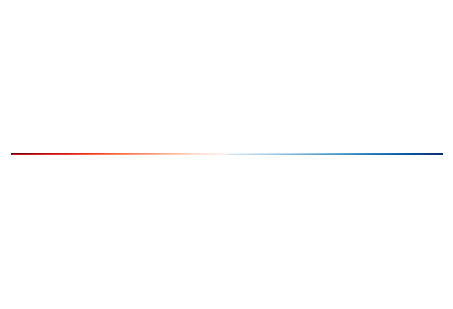

In [219]:
from matplotlib.transforms import Bbox

#cmap1 = plt.get_cmap('afmhot') 
#cmap1 = plt.get_cmap('copper') 
cmap1 = plt.get_cmap('Reds_r') 
cmap2 = plt.get_cmap('Blues')
npix = 256
gradient = np.linspace(0,1,npix)
g1 = np.linspace(0.2,1,npix)
gradient1 = np.vstack((gradient, g1))
g2 = np.linspace(0.2,1,npix)
gradient2 = np.vstack((gradient,g2))

f, ax = plt.subplots(1,2, sharex=True)

ax[0].imshow(gradient1, aspect = 1., cmap = cmap1)
ax[1].imshow(gradient2, aspect = 1., cmap = cmap2)

for a in ax:
    a.axis('off')
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)


f.subplots_adjust(bottom = 0, top = 1, right = 1, left = 0, hspace = 0, wspace = 0)
dpi = 72
box = Bbox.from_extents(0, 0, 1.69*npix/dpi, 2/dpi) #I don't understand this scaling in x

plt.savefig("data/cmapRedToBlue.png",bbox_inches = box, dpi = dpi, pad_inches=0, frameon = False)

## M82 position 

*From https://en.wikipedia.org/wiki/Messier_82*

In [10]:
from astropy.coordinates import SkyCoord, Distance
from astropy import units

In [11]:
RA = "9h 55m 52.2s" #right ascension
Dec= "69d 40m 47s" #declination
dist = (3500000 *units.pc).to(units.Mpc) #distance

coord = SkyCoord(RA, Dec, dist)

#print(coord.cartesian)
print(coord.galactic.cartesian)


(-2.07816693, 1.6584028, 2.27616396) Mpc


## Position  of SN 2014J in M82

https://en.wikipedia.org/wiki/SN_2014J

In [12]:
RA = "9h 55m 42.217s" #right ascension
Dec= "69d 40m 26.56s" #declination
dist = (3500000 *units.pc).to(units.Mpc) #distance

SNcoord = SkyCoord(RA, Dec, dist)

print(SNcoord.galactic.cartesian)

(-2.07892522, 1.65798914, 2.27577283) Mpc


In [13]:
offset = SNcoord.galactic.cartesian - coord.galactic.cartesian
print(offset)

(-0.00075829, -0.00041366, -0.00039114) Mpc
